In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
from utils.morpho_tagger import MorphoTagger
from gensim.models.fasttext import FastText
from functools import reduce
import argparse

class FastTextConfig:
    def __init__(self, embedding_size, window_size, min_word, down_sampling):
        self.embedding_size = embedding_size
        self.window_size = window_size
        self.min_word = min_word
        self.down_sampling = down_sampling
        
class FastTextSimilarityModel:
    def __init__(self, file_path, conf):
        self.sentences = []
        self.sentences_pos = []
        self.model_conf = conf
        self.model = None

        with open(file_path, "r", encoding='utf-8') as file:
            for line in file:
                self.sentences.append(line[:-1])

    def preprocess(self, tagger: MorphoTagger, sen=None):
        sentences_pos = []
        
        if not sen:
            sentences = self.sentences
        else:
            sentences = sen

        for sentence in sentences:
            s = []
            l = reduce(lambda x, y: x + y, tagger.pos_tagging(sentence, False))
            for idx, wp in enumerate(l):
                    s.append(wp.lemma)
            sentences_pos.append(s)

        if not sen:
            self.sentences_pos = sentences_pos
            return []
        else:
            return sentences_pos

    def train_similarity(self):
        self.model = FastText(self.sentences_pos,
                            size=self.model_conf.embedding_size,
                            window=self.model_conf.window_size,
                            min_count=self.model_conf.min_word,
                            sample=self.model_conf.down_sampling,
                            sg=1,
                            iter=100)

%matplotlib inline

In [2]:
%%time
tagger = MorphoTagger()
tagger.load_tagger("external/morphodita/czech-morfflex-pdt-161115-no_dia-pos_only.tagger")

conf = FastTextConfig(200, 10, 5, 1e-2)

fastTextModel = FastTextSimilarityModel("dataset_positive.txt", conf)
fastTextModel.preprocess(tagger)
fastTextModel.train_similarity()

CPU times: user 1min 10s, sys: 7.25 s, total: 1min 17s
Wall time: 45.7 s


In [3]:
semantically_similar_words = {words: [item[0] for item in fastTextModel.model.wv.most_similar([words], topn=5)]
                                      for words in
                                      ['cena', 'kabel', 
                                       'manipulace', 'hadice', 
                                       'nádoba', 'kabel', 
                                       'filtr','šnůra',
                                      'kvalita']}

for k, v in semantically_similar_words.items():
    print(k + ":" + str(v))

cena:['hladina', 'priznivy', 'versus', 'zdarma', 'pomer']
kabel:['kabela', 'napajeci', 'napajeni', 'gumovy', 'dosah']
manipulace:['manipulovat', 'snadny', 'vyprazdneni', 'pojezd', 'komunikace']
hadice:['prehazovat', 'trubice', 'gumovy', 'ohybat', 'otocny']
nádoba:['doba', 'nadoba', 'zakladna', 'cast', 'kratky']
filtr:['omyt', 'hepy', 'filtrace', 'omyvatelny', 'skladany']
šnůra:['optimalni', 'pvc', 'plocha', 'dcera', 'dlazba']
kvalita:['kvalitni', 'spolehlivost', 'variabilita', 'znamy', 'kvalitne']


In [4]:
print(fastTextModel.model.wv.similarity(w1='doba', w2='nádoba'))

0.86117834


In [5]:
from sklearn.decomposition import PCA

all_similar_words = sum([[k] + v for k, v in semantically_similar_words.items()], [])

print(all_similar_words)
print(type(all_similar_words))
print(len(all_similar_words))

['cena', 'hladina', 'priznivy', 'versus', 'zdarma', 'pomer', 'kabel', 'kabela', 'napajeci', 'napajeni', 'gumovy', 'dosah', 'manipulace', 'manipulovat', 'snadny', 'vyprazdneni', 'pojezd', 'komunikace', 'hadice', 'prehazovat', 'trubice', 'gumovy', 'ohybat', 'otocny', 'nádoba', 'doba', 'nadoba', 'zakladna', 'cast', 'kratky', 'filtr', 'omyt', 'hepy', 'filtrace', 'omyvatelny', 'skladany', 'šnůra', 'optimalni', 'pvc', 'plocha', 'dcera', 'dlazba', 'kvalita', 'kvalitni', 'spolehlivost', 'variabilita', 'znamy', 'kvalitne']
<class 'list'>
48


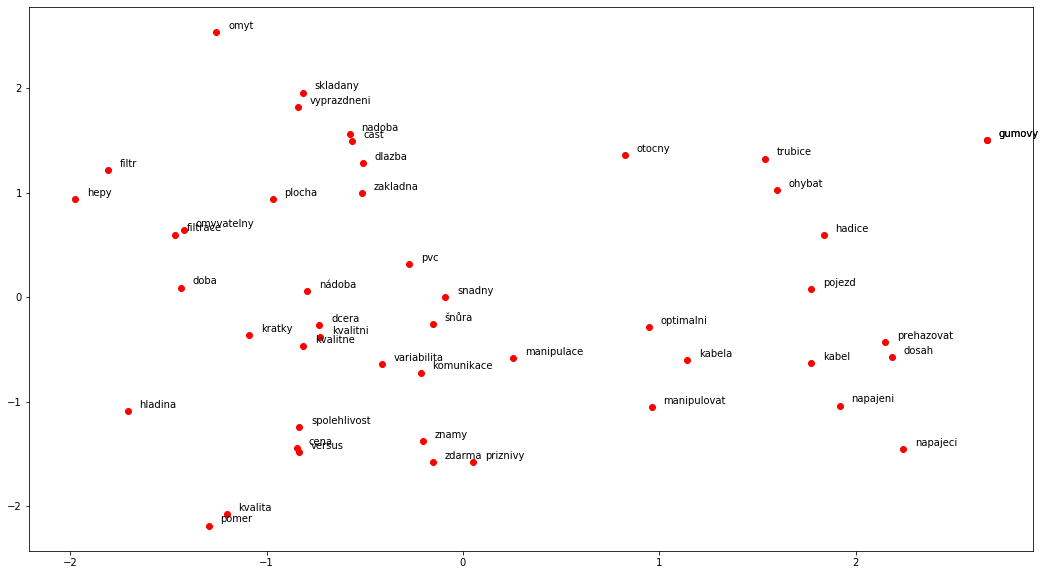

In [6]:
word_vectors = fastTextModel.model.wv[all_similar_words]

pca = PCA(n_components=2)

p_comps = pca.fit_transform(word_vectors)
word_names = all_similar_words

plt.figure(figsize=(18, 10))
plt.scatter(p_comps[:, 0], p_comps[:, 1], c='red')

for word_names, x, y in zip(word_names, p_comps[:, 0], p_comps[:, 1]):
    plt.annotate(word_names, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

In [7]:
s1 = ['vysoky', 'saci', 'vykon', 'vsechen', 'povrch']
s2 = ['skvet', 'saci', 'vykon']
distance = fastTextModel.model.wmdistance(s1, s2)
print('distance = %.4f' % distance)


distance = 3.5980


/home/andrej/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
